In [1]:
#pip install bayesian-optimization==0.6 --user

In [3]:
import numpy as np
import pandas as pd
import time
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

import math
from pylab import rcParams
import pandas_datareader as pdr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.11.1
scikit-learn==0.23.2
pandas==0.22.0
numpy==1.14.6
matplotlib==3.2.2


In [5]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

# Load Data

In [6]:
# 12-12-1980

# start = dt.datetime(2020, 1, 1)
# end = dt.datetime.now()

start = dt.datetime(2020, 8, 7)
end = dt.datetime(2021, 4, 16)
# end = dt.datetime.now()

df = pdr.get_data_yahoo("AAPL", start, end)
df.reset_index(inplace=True)

df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2020-08-07,113.675003,110.292503,113.205002,111.112503,198045600.0,110.755638
1,2020-08-10,113.775002,110.000000,112.599998,112.727501,212403600.0,112.365448
2,2020-08-11,112.482498,109.107498,111.970001,109.375000,187902400.0,109.023705
3,2020-08-12,113.275002,110.297501,110.497498,113.010002,165944800.0,112.647041
4,2020-08-13,116.042503,113.927498,114.430000,115.010002,210082000.0,114.640610


In [7]:
df.isnull().sum(axis=0).sum()

0

In [8]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [9]:
close = df["Open"].values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [10]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


In [11]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [12]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
               
    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:      
                
                if buy < 0:
                    buy = 1
                    buy_units = buy
                    total_buy = buy_units * close[t]
                    initial_money -= total_buy
                    inventory.append(total_buy)
                    quantity += buy_units
                
                if buy > self.max_buy:
                    if initial_money >= (self.max_buy * close[t]):
                        buy_units = self.max_buy
                        total_buy = buy_units * close[t]
                        initial_money -= total_buy
                        inventory.append(total_buy)
                        quantity += buy_units
         
                else:
                    if initial_money >= (buy * close[t]):
                        buy_units = buy
                        total_buy = buy_units * close[t]
                        initial_money -= total_buy
                        inventory.append(total_buy)
                        quantity += buy_units
                    
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity 
                    
#                 if inventory >= sell_units * close[t]    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            
#             print("action: {}".format(action))
#             print("buy: {}".format(buy))
            
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                
                if buy < 0:
                    buy = 1
                    buy_units = buy
                    total_buy = buy_units * close[t]
                    initial_money -= total_buy
                    inventory.append(total_buy)
                    quantity += buy_units
                    states_buy.append(t)
                    print(
                    'day %d: buy %d units at price %f, quantity %d, total balance %f'
                    % (t, buy_units, close[t], quantity, initial_money)
                ) # total_buy
                    
                if buy > self.max_buy:
                    if initial_money >= (self.max_buy * close[t]):
                        buy_units = self.max_buy
                        total_buy = buy_units * close[t]
                        initial_money -= total_buy
                        inventory.append(total_buy)
                        quantity += buy_units
                        states_buy.append(t)
                        print(
                            'day %d: buy %d units at price %f, quantity %d, total balance %f'
                            % (t, buy_units, close[t], quantity, initial_money)
                        ) # total_buy
                else:
                    if initial_money >= (buy * close[t]):
                        buy_units = buy
                        total_buy = buy_units * close[t]
                        initial_money -= total_buy
                        inventory.append(total_buy)
                        quantity += buy_units
                        states_buy.append(t)
                        print(
                            'day %d: buy %d units at price %f, quantity %d, total balance %f'
                            % (t, buy_units, close[t], quantity, initial_money)
                        ) # total_buy
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, quantity %d, total balance %f,'
                    % (t, sell_units, close[t], quantity, initial_money) #(t, sell_units, close[t], invest, initial_money)
                     
                ) # total_sell
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\n Total Profit: %f dollar \n Return of Investment: %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        
        plt.plot(close, '^', label = 'Buy', markevery = states_buy, color="green")  
        plt.plot(close, 'x', label = 'Sell', markevery = states_sell, color="red")    
        plt.plot(close, label = 'AMZN Open', color="#0343DF", alpha=0.5)   
        
        plt.title("Automated Trading Buy and Sell Decisions For Amazon.com, Inc. Based on Evolution Strategy", fontsize = 20, fontweight ="bold")
        plt.xlabel("Time Period (Aug.7, 2020 - Apr.16, 2021)",fontsize = 16, fontweight ="bold")
        plt.ylabel("Security Price", fontsize = 16, fontweight ="bold")
        plt.legend(loc = "best", fontsize = 12)
        plt.show()

In [13]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        1000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [14]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [15]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 45, 'skip': 4, 'population_size': 4, 'sigma': 0.44791379124489733, 'learning_rate': 0.0052200609394501005, 'size_network': 174}
time taken to train: 0.6417920589447021 seconds
stop after 100 iteration with investment -37.379251
    1 | 00m00s |  -37.37925 |          0.0052 |            3.6567 |    0.4479 |       173.6761 |    4.0464 |       44.7767 | 

Search parameters {'window_size': 6, 'skip': 7, 'population_size': 28, 'sigma': 0.9136011832776963, 'learning_rate': 0.32510990788673994, 'size_network': 706}
time taken to train: 3.548157215118408 seconds
stop after 100 iteration with investment 31.521759
    2 | 00m03s |   31.52176 |          0.3251 |           28.2470 |    0.9136 |       7

/Users/Reinhard/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
    3 | 00m00s |    0.00000 |          0.1828 |           37.2205 |    0.0130 |       981.2294 |    4.3563 |       38.7750 | 

Search parameters {'window_size': 29, 'skip': 10, 'population_size': 46, 'sigma': 0.39975179948099554, 'learning_rate': 0.12311173109910273, 'size_network': 266}
time taken to train: 5.754187107086182 seconds
stop after 100 iteration with investment 24.030500
    4 | 00m05s |   24.03050 |          0.1231 |           45.9295 |    0.3998 |       265.5514 |   10.1394 |       29.2772 | 

Search parameters {'window_size': 7, 'skip': 5, 'population_size': 18, 'sigma': 0.8291997264537005, 'learning_rate': 0.38524070411411, 'size_network': 10}
time taken to train: 0.9087719917297363 seconds
stop after 100 iteration with investment 30.639758
    5 | 00m00s |   30.63976 |          0.3852 |           18.2077 |    0.8292 |        10.1693 |    5.3403 |        6.6717 | 

Search parameters {'window_size': 3, 'skip': 12, 'popul

/Users/Reinhard/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 40, 'skip': 3, 'population_size': 49, 'sigma': 0.17768831476150962, 'learning_rate': 0.2285211961813938, 'size_network': 31}
time taken to train: 5.850354909896851 seconds
stop after 100 iteration with investment 57.473749
   39 | 00m06s |   57.47375 |          0.2285 |           49.1468 |    0.1777 |        30.9125 |    2.7133 |       39.9750 | 

Search parameters {'window_size': 20, 'skip': 10, 'population_size': 25, 'sigma': 0.3549370464157652, 'learning_rate': 0.47855782985361606, 'size_network': 753}
time taken to train: 3.9762349128723145 seconds
stop after 100 iteration with investment 30.015501
   40 | 00m05s |   30.01550 |          0.4786 |           24.7660 |    0.3549 |       752.8435 |    9.8425 |       19.7514 | 

Search parameters {'window_size': 16, 'skip': 7, 'population_size': 32, 'sigma': 0.7826935901985501, 'learning_rate': 0.19695121923875863, 'size_network': 428}
time taken to train: 3.7018861770629883 seconds
stop after 100 itera

/Users/Reinhard/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 13, 'skip': 3, 'population_size': 6, 'sigma': 0.5945323729797394, 'learning_rate': 0.1567776692653103, 'size_network': 162}
time taken to train: 0.6450519561767578 seconds
stop after 100 iteration with investment 51.197253
   53 | 00m01s |   51.19725 |          0.1568 |            5.7395 |    0.5945 |       162.0434 |    2.6981 |       12.8995 | 

Search parameters {'window_size': 38, 'skip': 2, 'population_size': 31, 'sigma': 0.635020727313441, 'learning_rate': 0.0473041772380157, 'size_network': 964}
time taken to train: 17.783442974090576 seconds
stop after 100 iteration with investment 24.875499
   54 | 00m18s |   24.87550 |          0.0473 |           31.0043 |    0.6350 |       963.9223 |    2.3197 |       37.8579 | 

Search parameters {'window_size': 10, 'skip': 10, 'population_size': 23, 'sigma': 0.5799880042170025, 'learning_rate': 0.09908368186847574, 'size_network': 524}
time taken to train: 2.041707992553711 seconds
stop after 100 iteratio

/Users/Reinhard/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   59 | 00m03s |    0.00000 |          0.1004 |           16.5413 |    0.2712 |       423.0724 |   10.7097 |       47.5041 | 

Search parameters {'window_size': 22, 'skip': 7, 'population_size': 3, 'sigma': 0.7742507852082359, 'learning_rate': 0.021219203062724304, 'size_network': 80}
time taken to train: 0.17607402801513672 seconds
stop after 100 iteration with investment -16.959000
   60 | 00m01s |  -16.95900 |          0.0212 |            3.1607 |    0.7743 |        79.6445 |    7.2462 |       22.1734 | 

Search parameters {'window_size': 49, 'skip': 2, 'population_size': 4, 'sigma': 0.44311319431031393, 'learning_rate': 0.007803939570341996, 'size_network': 518}
time taken to train: 1.9219110012054443 seconds
stop after 100 iteration with investment 6.196760
   61 | 00m03s |    6.19676 |          0.0078 |            4.1358 |    0.4431 |       518.1725 |    2.3572 |       49.4451 | 

Search parameters {'window_size': 29, 'skip': 13, 

/Users/Reinhard/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 4, 'skip': 12, 'population_size': 30, 'sigma': 0.33203505194113686, 'learning_rate': 0.09675337608488643, 'size_network': 753}
time taken to train: 2.143627882003784 seconds
stop after 100 iteration with investment 25.319250
   67 | 00m03s |   25.31925 |          0.0968 |           29.8188 |    0.3320 |       752.9572 |   12.2548 |        4.1090 | 

Search parameters {'window_size': 8, 'skip': 6, 'population_size': 12, 'sigma': 0.7064110509746868, 'learning_rate': 0.09471706273906706, 'size_network': 298}
time taken to train: 1.0654420852661133 seconds
stop after 100 iteration with investment 19.111502
   68 | 00m02s |   19.11150 |          0.0947 |           12.1567 |    0.7064 |       297.9217 |    6.4426 |        8.1120 | 

Search parameters {'window_size': 15, 'skip': 6, 'population_size': 7, 'sigma': 0.5210672798421885, 'learning_rate': 0.40273646720908934, 'size_network': 388}
time taken to train: 0.8060240745544434 seconds
stop after 100 iterat

/Users/Reinhard/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   74 | 00m02s |    0.00000 |          0.3293 |           25.0975 |    0.1597 |       583.3356 |   13.2992 |       29.0558 | 

Search parameters {'window_size': 29, 'skip': 6, 'population_size': 33, 'sigma': 0.759430127339691, 'learning_rate': 0.2559277520977647, 'size_network': 717}
time taken to train: 7.606026887893677 seconds
stop after 100 iteration with investment 42.583498
   75 | 00m09s |   42.58350 |          0.2559 |           32.5818 |    0.7594 |       717.3405 |    5.8310 |       29.4595 | 

Search parameters {'window_size': 22, 'skip': 4, 'population_size': 26, 'sigma': 0.46654863268375035, 'learning_rate': 0.45871930424578106, 'size_network': 887}
time taken to train: 7.282999038696289 seconds
stop after 100 iteration with investment 56.166508
   76 | 00m08s |   56.16651 |          0.4587 |           26.0016 |    0.4665 |       887.2583 |    3.8667 |       22.0428 | 

Search parameters {'window_size': 28, 'skip': 6, 'popu

/Users/Reinhard/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   77 | 00m01s |    0.00000 |          0.1467 |           18.1797 |    0.0663 |       134.8992 |    6.2546 |       28.3402 | 

Search parameters {'window_size': 46, 'skip': 11, 'population_size': 14, 'sigma': 0.7304901178903305, 'learning_rate': 0.3550905811348691, 'size_network': 497}
time taken to train: 2.672517776489258 seconds
stop after 100 iteration with investment 32.274244
   78 | 00m04s |   32.27424 |          0.3551 |           14.0768 |    0.7305 |       497.2730 |   11.2588 |       46.3984 | 

Search parameters {'window_size': 30, 'skip': 6, 'population_size': 9, 'sigma': 0.9429803831180933, 'learning_rate': 0.10956091220042623, 'size_network': 519}
time taken to train: 1.7131588459014893 seconds
stop after 100 iteration with investment 27.755254
   79 | 00m03s |   27.75525 |          0.1096 |            8.7878 |    0.9430 |       518.7494 |    6.0058 |       29.5966 | 

Search parameters {'window_size': 10, 'skip': 3, 'pop

In [16]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 113.128995
Best AGENT parameters:  {'window_size': 47.40013742330881, 'skip': 1.24615352624979, 'population_size': 32.10635198976653, 'sigma': 0.4203103242514349, 'learning_rate': 0.46435335956999674, 'size_network': 265.1442899097823}


#### My selected parameters

In [17]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 9.925251960754395 seconds


78.8722396850586

#### bayesian parameters

In [18]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
    sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
    learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network']))
)

time taken to train: 21.699686288833618 seconds


114.43650512695311

#### My selected parameters

In [19]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              model = model, 
              money = 1000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
# agent.fit(500, 100)
# agent.buy()

In [20]:
agent.fit(500, 50)

iter 50. reward: 40.229501
iter 100. reward: 43.686257
iter 150. reward: 68.945261
iter 200. reward: 79.041014
iter 250. reward: 81.557256
iter 300. reward: 84.193754
iter 350. reward: 92.799251
iter 400. reward: 89.845750
iter 450. reward: 94.481997
iter 500. reward: 97.220760
time taken to train: 49.363078117370605 seconds


day 1: buy 1 units at price 112.599998, quantity 1, total balance 887.400002
day 1: buy 1 units at price 112.599998, quantity 2, total balance 774.800003
day 2: buy 5 units at price 111.970001, quantity 7, total balance 214.949997
day 4, sell 5 units at price 114.430000, quantity 2, total balance 787.099998,
day 5: buy 1 units at price 114.830002, quantity 3, total balance 672.269997
day 5: buy 1 units at price 114.830002, quantity 4, total balance 557.439995
day 6, sell 4 units at price 116.062500, quantity 0, total balance 1021.689995,
day 15: buy 1 units at price 126.012497, quantity 1, total balance 895.677498
day 15: buy 1 units at price 126.012497, quantity 2, total balance 769.665001
day 16: buy 1 units at price 127.580002, quantity 3, total balance 642.084999
day 16: buy 1 units at price 127.580002, quantity 4, total balance 514.504997
day 18, sell 4 units at price 137.589996, quantity 0, total balance 1064.864983,
day 21: buy 5 units at price 113.949997, quantity 5, total bala

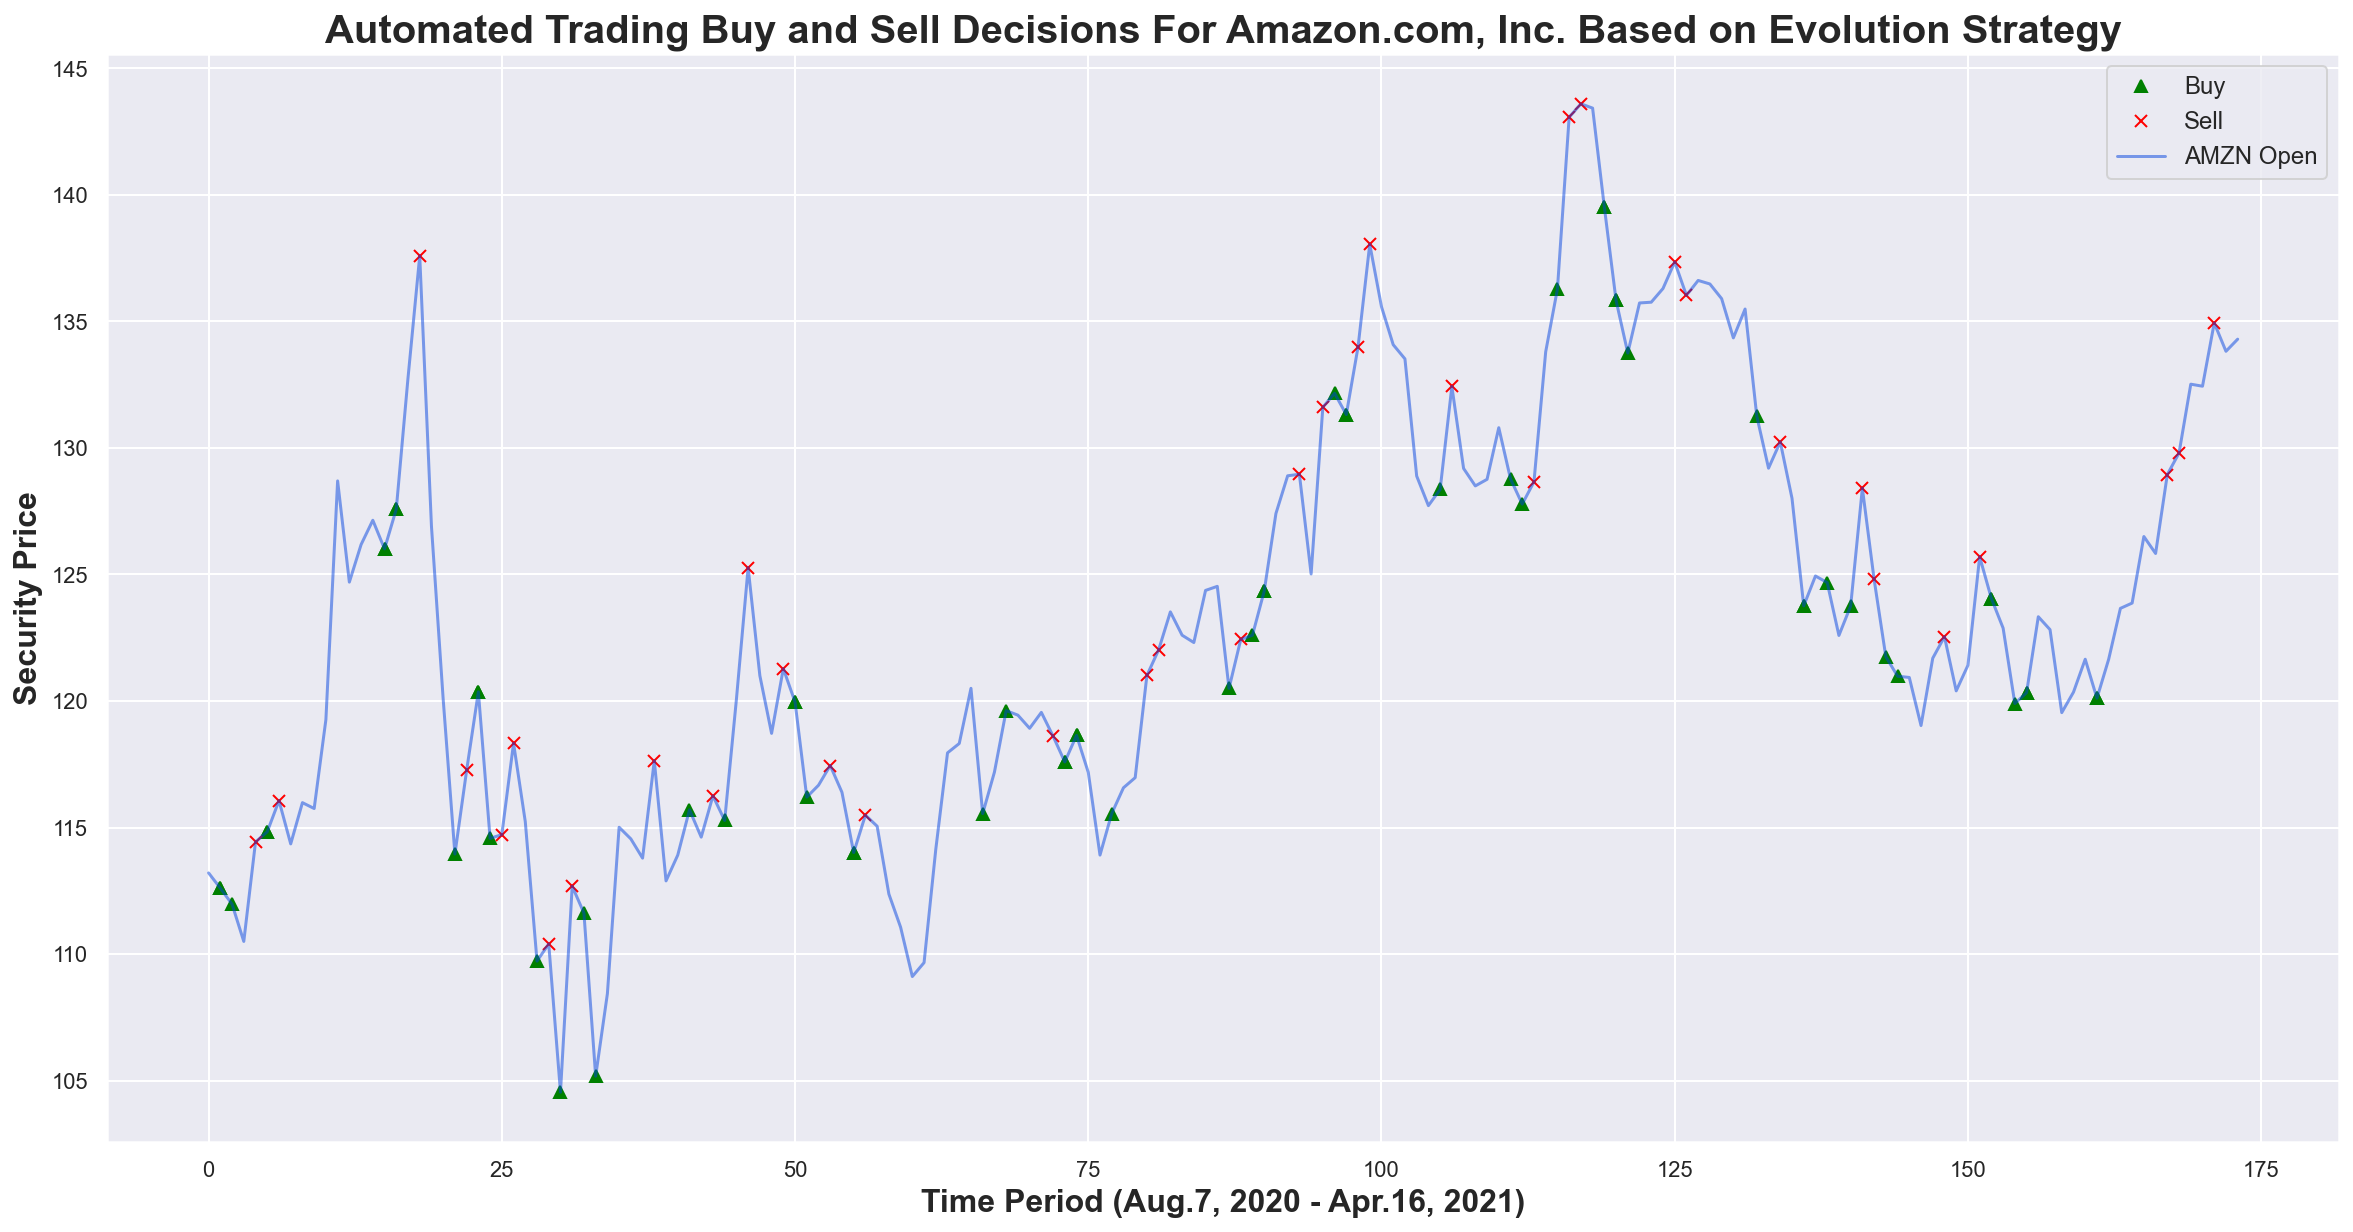

In [22]:
agent.buy()

#### bayesian parameters

In [23]:
model = Model(input_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
              layer_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
              sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
              learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
              model = model, 
              money = 1000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])))
# agent.fit(500, 100)
# agent.buy()

In [24]:
agent.fit(500, 50)

iter 50. reward: 100.071764
iter 100. reward: 110.824257
iter 150. reward: 113.322765
iter 200. reward: 124.051765
iter 250. reward: 129.228772
iter 300. reward: 131.932769
iter 350. reward: 134.098774
iter 400. reward: 134.936773
iter 450. reward: 138.406772
iter 500. reward: 139.026765
time taken to train: 108.07453989982605 seconds


day 0: buy 1 units at price 113.205002, quantity 1, total balance 886.794998
day 0: buy 1 units at price 113.205002, quantity 2, total balance 773.589996
day 1: buy 1 units at price 112.599998, quantity 3, total balance 660.989998
day 1: buy 1 units at price 112.599998, quantity 4, total balance 548.389999
day 2: buy 1 units at price 111.970001, quantity 5, total balance 436.419998
day 2: buy 1 units at price 111.970001, quantity 6, total balance 324.449997
day 3: buy 1 units at price 110.497498, quantity 7, total balance 213.952499
day 3: buy 1 units at price 110.497498, quantity 8, total balance 103.455002
day 5, sell 5 units at price 114.830002, quantity 3, total balance 677.605011,
day 6: buy 5 units at price 116.062500, quantity 8, total balance 97.292511
day 9, sell 5 units at price 115.750000, quantity 3, total balance 676.042511,
day 10: buy 5 units at price 119.262497, quantity 8, total balance 79.730026
day 11, sell 5 units at price 128.697495, quantity 3, total balance 723.2

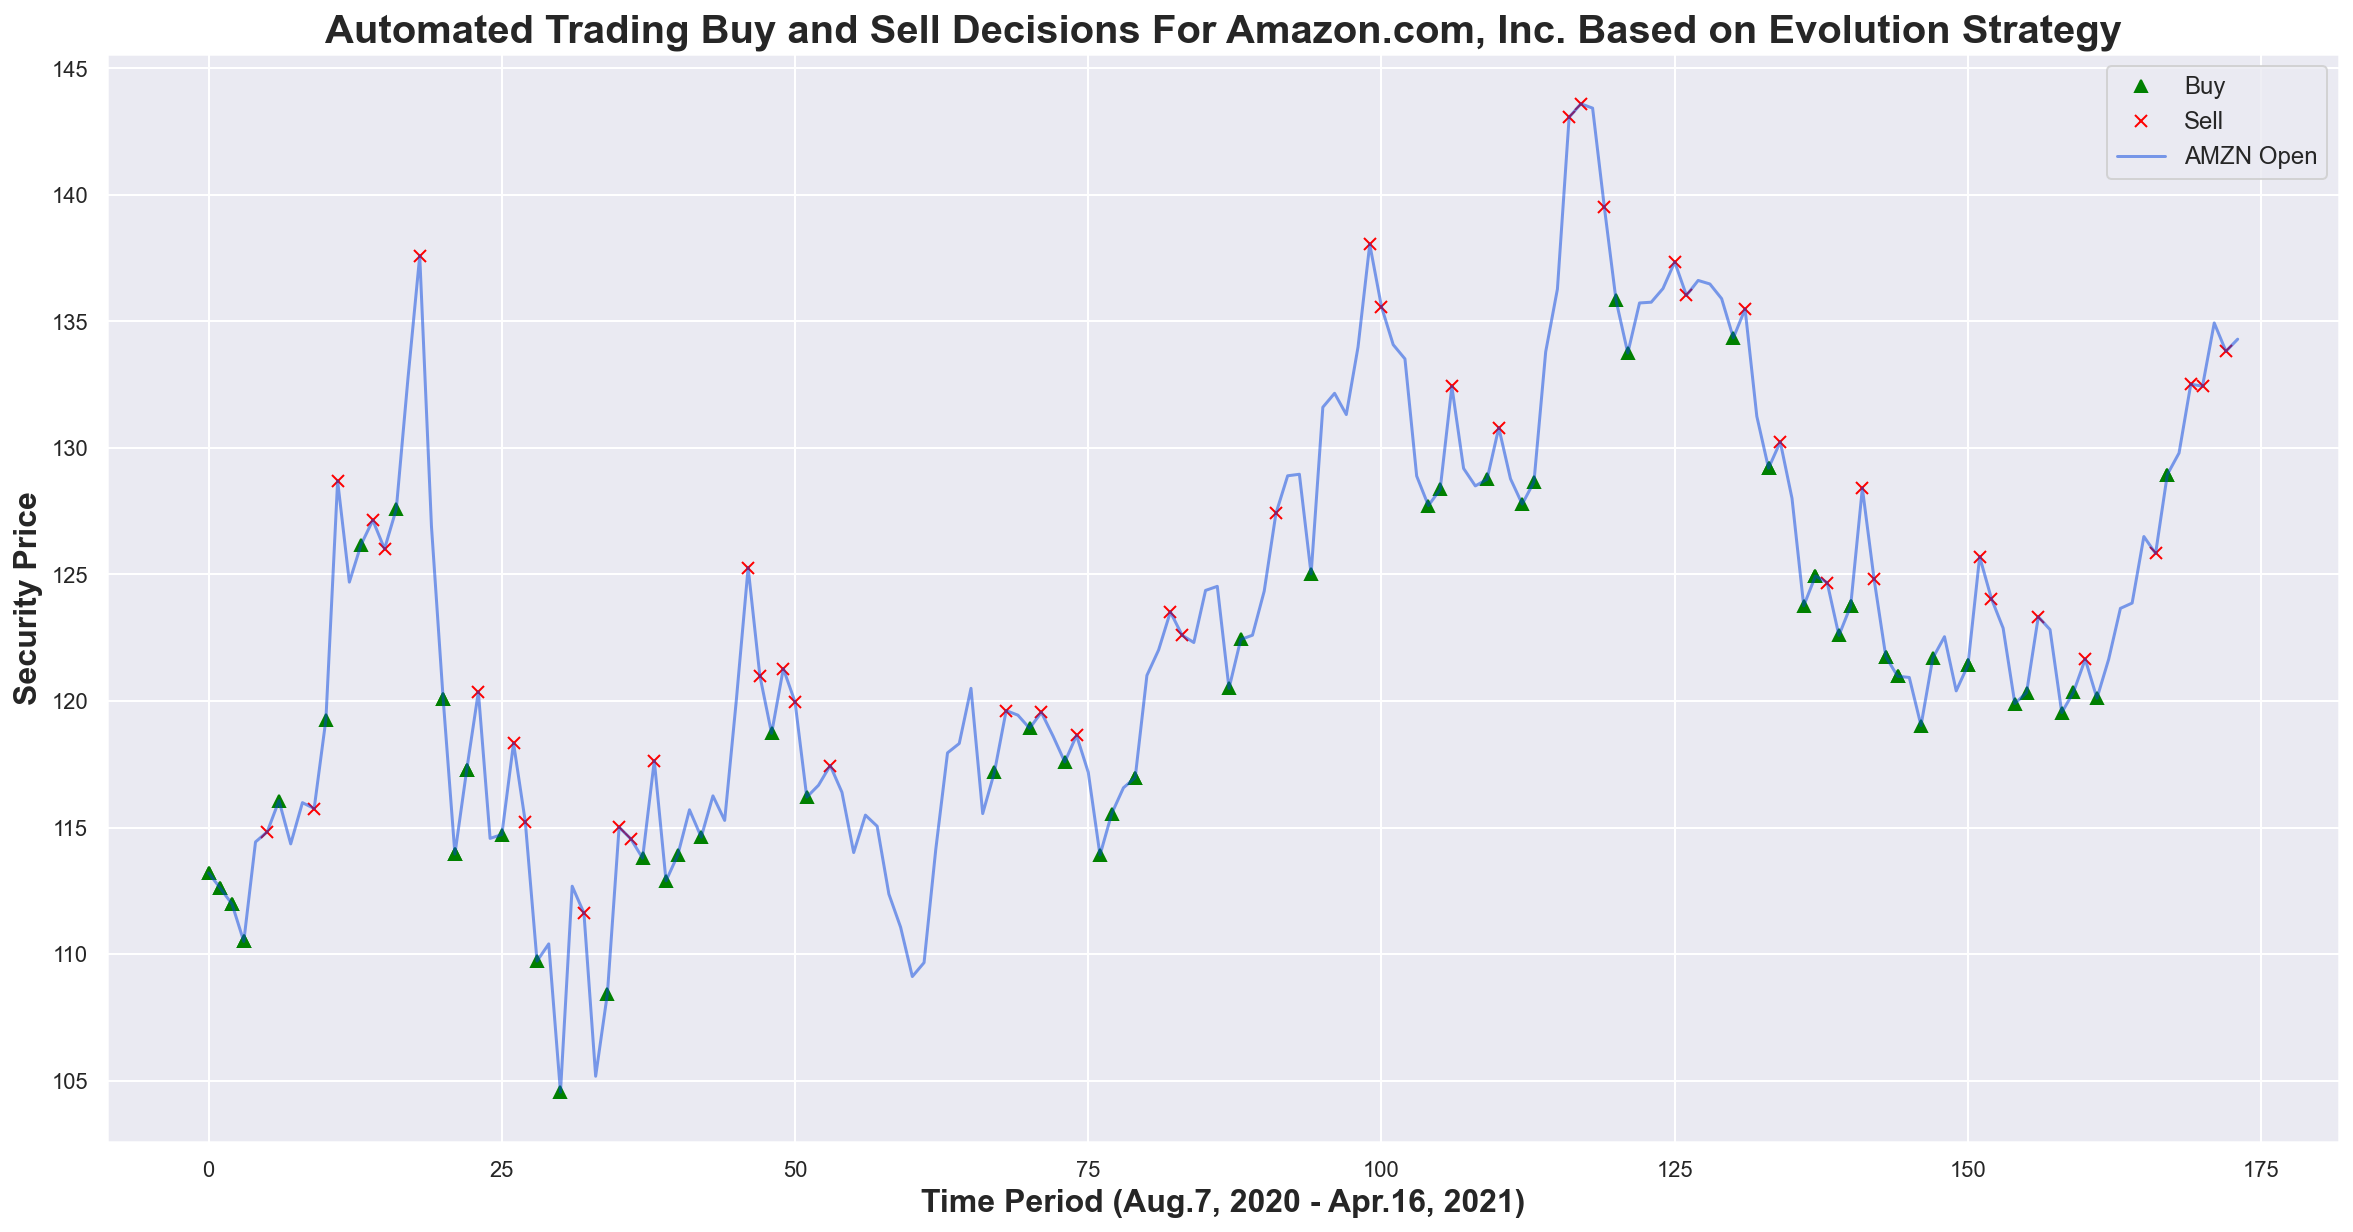

In [25]:
agent.buy()

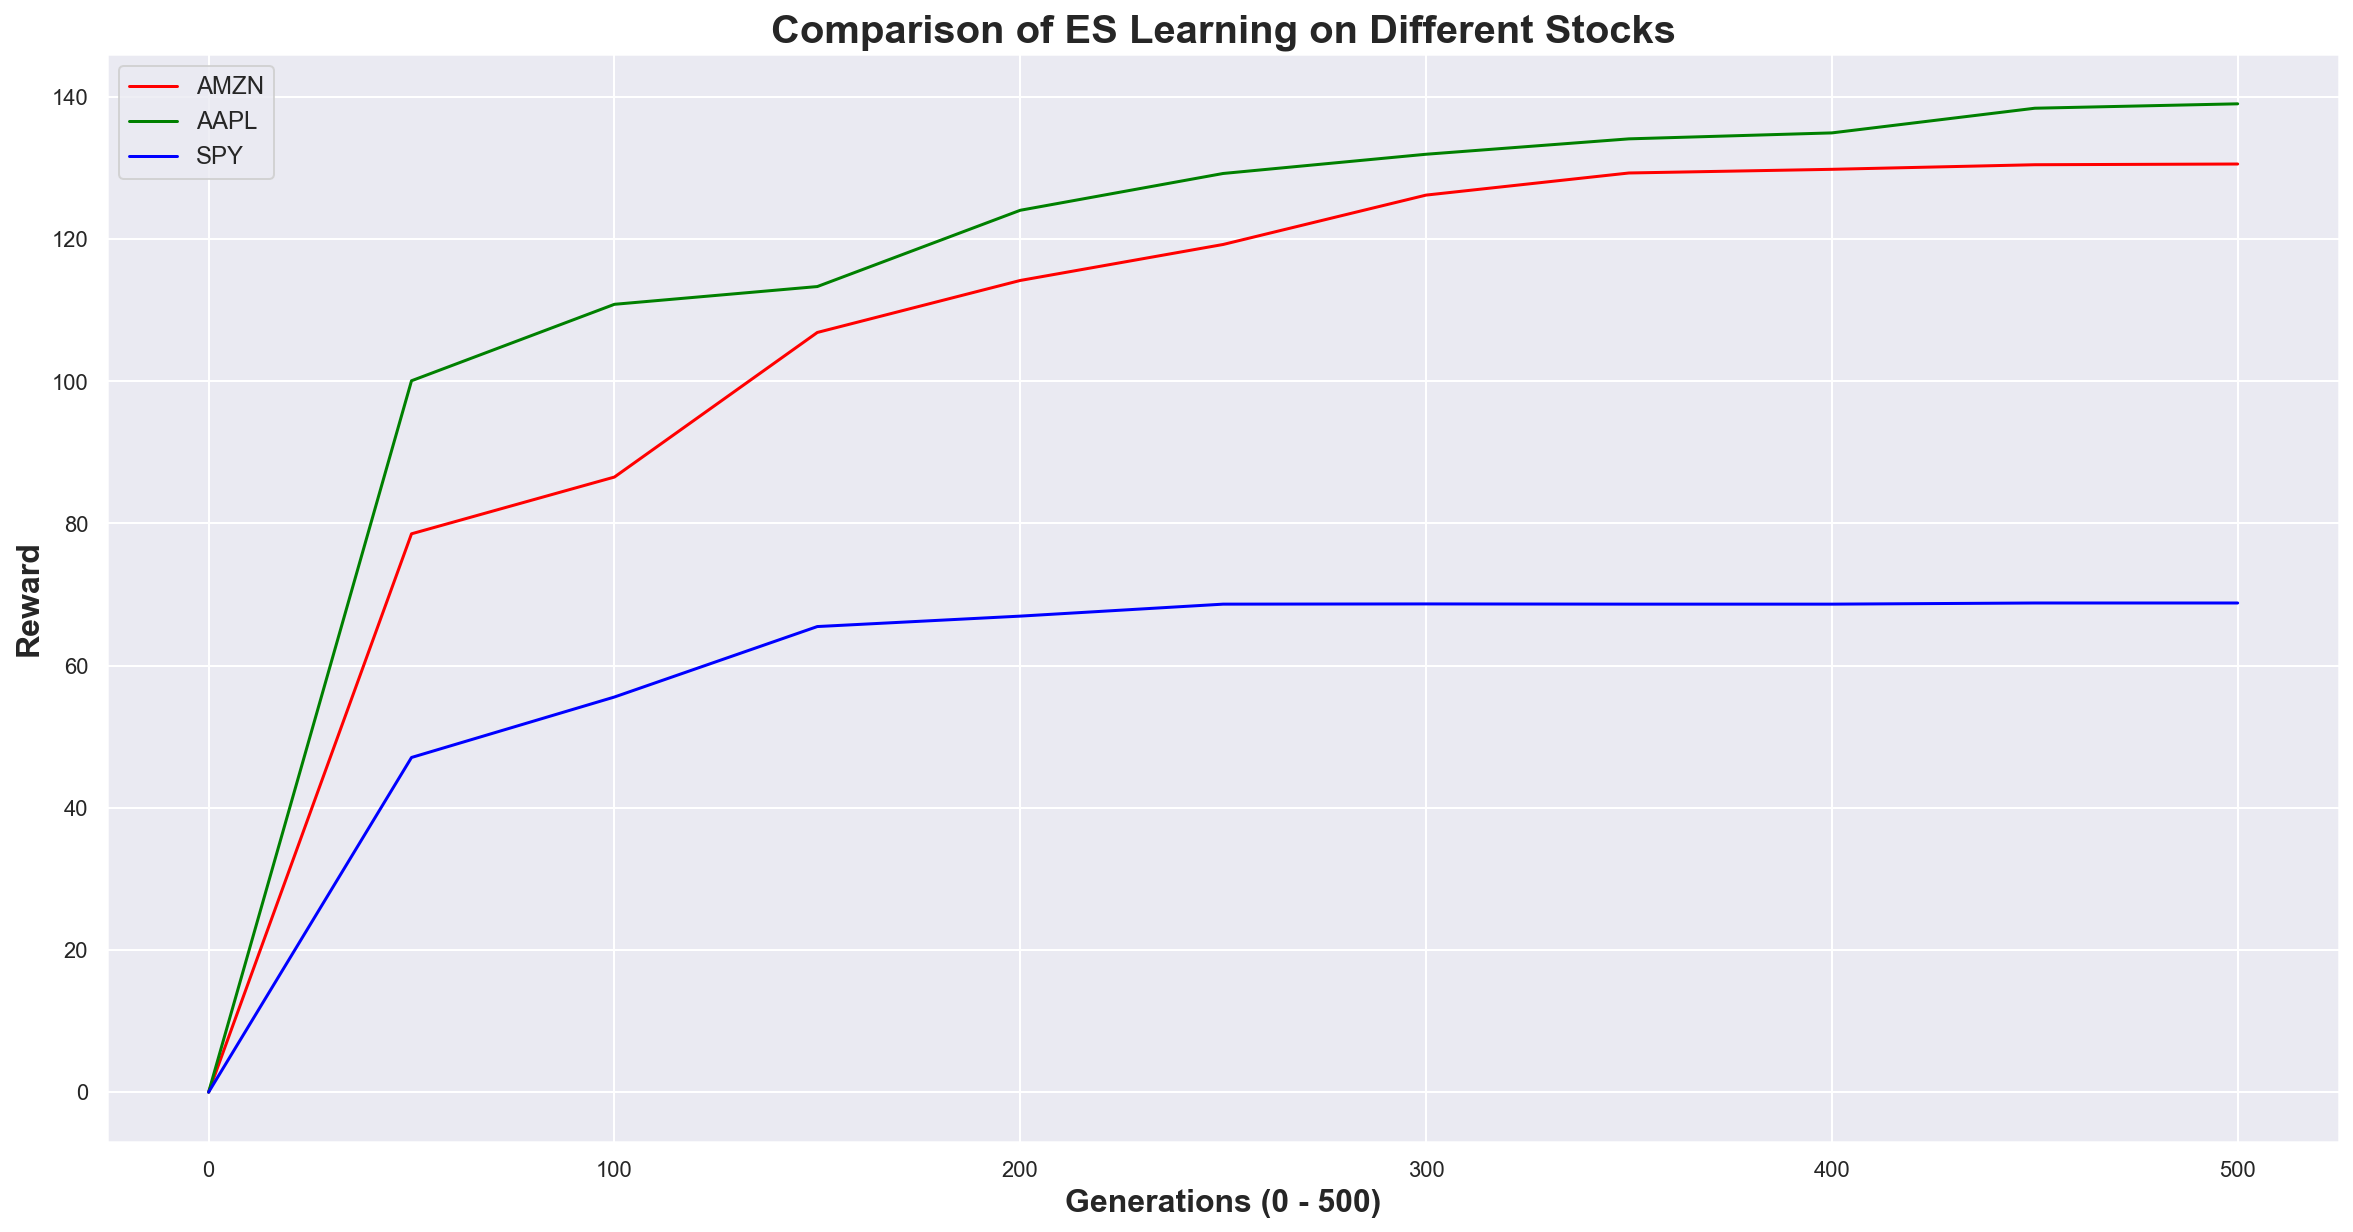

In [27]:
iters = [0,50,100,150,200,250,300,350,400,450,500]

reward_AMZN = [0, 78.543904, 86.526399, 106.865093, 114.178994, 119.241995, 126.186797, 129.297397, 129.813391, 130.458591, 130.558591]
#117.76878906249999
reward_AAPL = [0, 100.071764, 110.824257, 113.322765, 124.051765, 129.228772, 131.932769, 134.098774, 134.936773, 138.406772, 139.026765]
#100.8314910888672
reward_SPY = [0, 47.081018, 55.585025, 65.497009, 66.964014, 68.649011, 68.680011, 68.649011, 68.649011, 68.810007, 68.810007]
# 61.49100341796875

plt.figure(figsize = (20, 10))
        
plt.plot(reward_AMZN, '-', label = 'AMZN', color="red")  
plt.plot(reward_AAPL, '-', label = 'AAPL', color="green")    
plt.plot(reward_SPY, '-', label = 'SPY', color="blue")  
        
plt.title("Comparison of ES Learning on Different Stocks", fontsize = 20, fontweight ="bold")
plt.xticks([0,2,4,6,8,10], [0,100,200,300,400,500])
plt.xlabel("Generations (0 - 500)",fontsize = 16, fontweight ="bold")
plt.ylabel("Reward", fontsize = 16, fontweight ="bold")
plt.legend(loc = "best", fontsize = 12)

plt.show()
